Let's load our recordings and extract the spectrogram from a random recording:

In [1]:
from os import listdir
from random import choice
import pylab
import wave
import numpy as np
#from scipy.io import wavfile

In [2]:
def wavInfo(rec_file):
    wav_file = wave.open(rec_file, 'r')
    frames = wav_file.readframes(-1)
    wave_info = pylab.fromstring(frames, 'Int16') #all .wavs in our dataset are 16bit
    framerate = wav_file.getframerate()
    wav_file.close()
    return wave_info, framerate

In [3]:
 def graphSpec(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    print("Max frequency is %s" % framerate)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.xlabel("Time (s)")
    pylab.ylabel("Frequency (Hz)")
    pylab.subplot(111)
    pylab.title('Spectrogram of %s' % rec_file)
    spectrum, freqs, t, im = pylab.specgram(wave_info, NFFT=512, window=pylab.window_hanning, Fs=framerate)
    pylab.show()
    return spectrum, freqs, t, im
    #pylab.savefig("%s_spectrogram.png" % rec_file)

In [4]:
 def specInfo(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    spectrum, freqs, t, _ = pylab.specgram(wave_info, NFFT=512, window=pylab.window_hanning, Fs=framerate)
    return spectrum, freqs, t
    #pylab.savefig("%s_spectrogram.png" % rec_file)

In [5]:
dataset_dir = '../dataset/recordings/'
recordings = listdir(dataset_dir) #put path to dataset in your machine. not uploading dataset to github
rec_file = dataset_dir + choice(recordings)
print("Extracting spectrogram from %s\n" %(rec_file))
"""periodograms, freqs, times, img = graphSpec(rec_file)
print("image data: ", img)
print("size of frequency data: ", len(freqs))
print("frequency data: ", freqs)
print("size of time data: ", len(times))
print("time data: ", times)
print("size of spectrum data", len(periodograms), " X ", len(periodograms[0]))
print("spectrum data: ", periodograms)"""

Extracting spectrogram from ../dataset/recordings/Gb005-2014-10-06_05-50.wav



'periodograms, freqs, times, img = graphSpec(rec_file)\nprint("image data: ", img)\nprint("size of frequency data: ", len(freqs))\nprint("frequency data: ", freqs)\nprint("size of time data: ", len(times))\nprint("time data: ", times)\nprint("size of spectrum data", len(periodograms), " X ", len(periodograms[0]))\nprint("spectrum data: ", periodograms)'

pylab.specgram returns [4 things](http://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.specgram.html) :
* spectrum: a 2D array whose columns are the periodograms (see glossary) of successive segments
* freqs: a 1D array which contains the frequencies corresponding to the rows in spectrum 
* t: a 1D array which contains the times corresponding to the midpoint of segments (columns in spectrum)
* im: image of the spectrogram

In our case, freqs will be an array of size 257  
(44100 / 512 (number of points in our NFTT window) ~= 86.132 -> 22500 (Actual max freq) / 86.132 = 256 + 1 (for remaining frequency)  
Most of our recordings are ~1min and we end up with 6919 points in our time domain  
Each row in spectrum is a frequency value and each column in that row corresponds to the amplitude (??) at the point in time where that frquency appears  

We'll use the following functions to modify the results from our spectrogram and replot it with the data we need:  

In [6]:
# search for the index of the rightmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def leftmostBinSearch(A, lo, hi, target):
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 >= target):
        if (mid > 0 and A[mid - 1] > target):
            return leftmostBinSearch(A, lo, mid-1, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

# search for the index of the leftmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def rightmostBinSearch(A, lo, hi, target): # something is wrong and it's giving me 1 to the right 
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 <= target):
        if (mid < (len(A) - 1) and A[mid + 1] <= target):
            return leftmostBinSearch(A, mid, hi, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

In [7]:
# get modified spectrum of frequencies and times that matter to us
def specMod(spectrum, freqs, times, f1, f2, t1, t2):
    spectrumMod = [spectrum[f1][t1:t2]]
    for f in range(f1+1, f2): # check when fix right limit
            spectrumMod = spectrumMod+ [spectrum[f][t1:t2]]
    return spectrumMod

In [8]:
# based off: http://stackoverflow.com/questions/15961979/how-do-i-plot-a-spectrogram-the-same-way-that-pylabs-specgram-does
# plot the spectrogram of our region of interest
def plotModSpec(specMod, freqs, times, file):
    
    pylab.figure(num=None, figsize=(19, 12))
    pylab.xlabel("Time (s)")
    pylab.ylabel("Frequency (Hz)")
    pylab.title('Spectrogram of %s' % file)
    pylab.axis('tight')
    pylab.xlim(times[0],times[-1])
    pylab.pcolormesh(times, freqs, 10 * pylab.log10(specMod))
    pylab.axis('tight')
    pylab.ylim(freqs[0],freqs[-1])
    pylab.show()

Max frequency is 44100


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


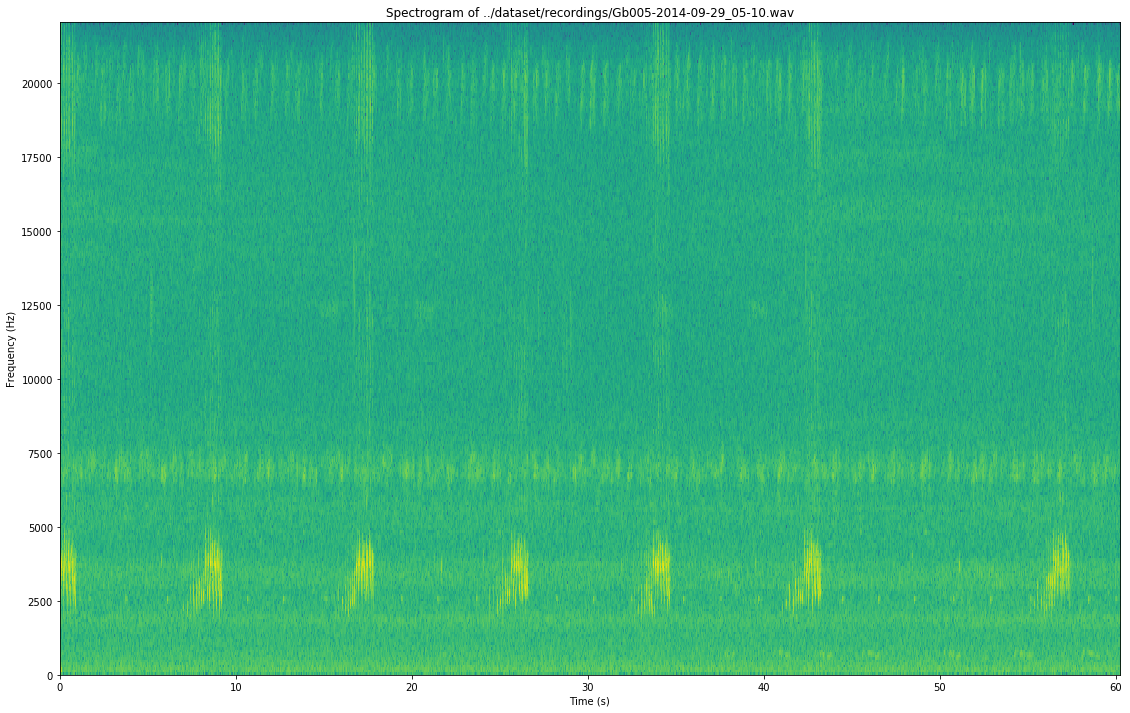

In [9]:
test = '../dataset/recordings/Gb005-2014-09-29_05-10.wav'
spectrum, freqs, times, _ = graphSpec(test)

In [10]:
def getBounds(A, minVal, maxVal):
    left = leftmostBinSearch(A, 0, len(A)-1, minVal)
    right = rightmostBinSearch(A, 0, len(A)-1, maxVal)
    return left, right

times start at position:  4684  which is  40.7916553288
times end at position:  4953  which is  43.133968254
freqs start at position:  21  which is  1808.7890625
freqs end at position:  63  which is  5426.3671875


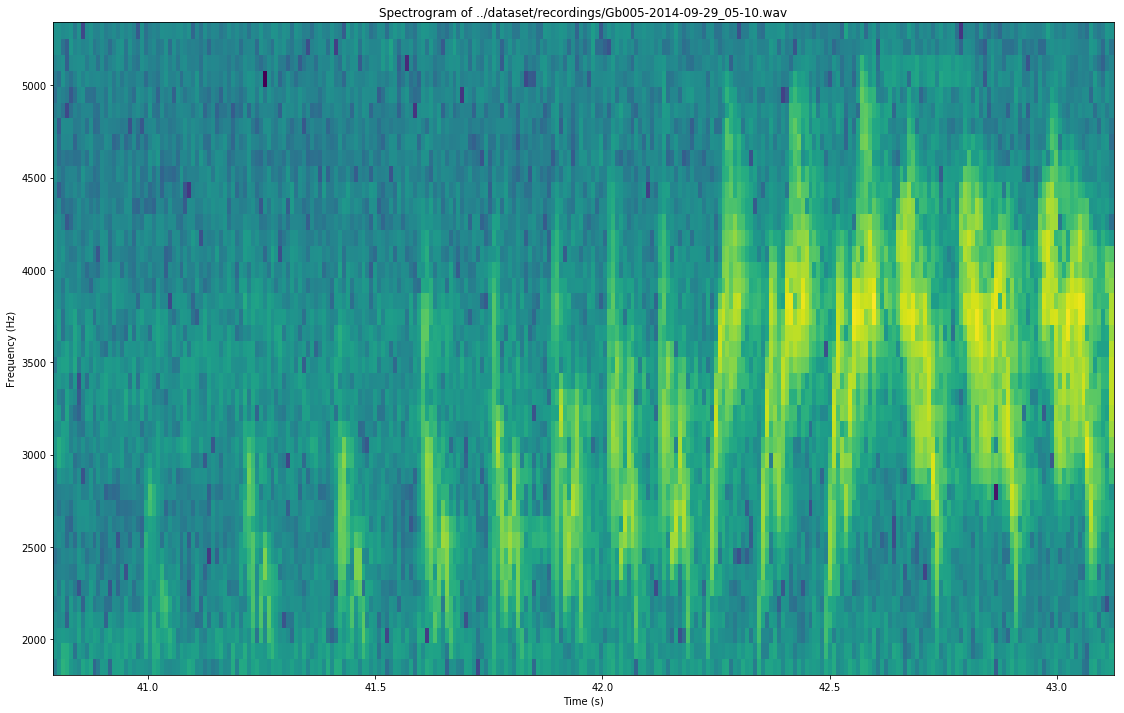

In [13]:
t_start, t_end = getBounds(times, 40.78952156, 43.1253411)
f_start, f_end = getBounds(freqs, 1805.818966, 5341.422414)

spectrumMod = specMod(spectrum, freqs, times, f_start, f_end, t_start, t_end)
print("times start at position: ", t_start, " which is ", times[t_start])
print("times end at position: ", t_end, " which is ", times[t_end])
print("freqs start at position: ", f_start, " which is ", freqs[f_start])
print("freqs end at position: ", f_end, " which is ", freqs[f_end])
#print(spectrumMod)
freqMod = freqs[f_start:f_end]
timeMod = times[t_start:t_end]
plotModSpec(spectrumMod, freqMod, timeMod, test)

## References:
* [why pylab?](http://stackoverflow.com/questions/23451028/matplotlib-pyplot-vs-matplotlib-pylab)
* [.wav to spectrogram code](http://coreygoldberg.blogspot.com/2013/06/generating-audio-spectrograms-in-python.html)
* [general info about .wav files](https://web.archive.org/web/20140221054954/http://home.roadrunner.com/~jgglatt/tech/wave.htm)